### checking if the gpu is detected by Pytorch


In [1]:
import torch
print(torch.cuda.is_available())

True


### importing dependencies

In [11]:
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from torch.autograd import Function
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### preprocessing the images
##### resize,changing to tensors and normalising

In [3]:
#the transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Define the DenseNet model

In [4]:

model = models.densenet121(pretrained=True) #pretrained weights are loaded
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)  # classes are meme and not_meme

c:\Users\Sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
#the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Creating data loaders

In [7]:
# Define the data loaders
train_dataset = ImageFolder(
    "G:\\ProjectsDocs\\memes\\memes_dataset\\train", transform=transform)
test_dataset = ImageFolder(
    "G:\\ProjectsDocs\\memes\\memes_dataset\\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Training

##### fetching accuracy, loss and classification report in every epoch, saving the best weights (with best accuracy)

In [8]:
import csv

# Initialize CSV logger
csv_file = 'training_log.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['epoch', 'train_loss', 'val_accuracy',
                    'val_precision', 'val_recall', 'val_f1'])

In [9]:
# Initialize lists to store metrics
train_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

In [12]:
num_epochs = 20
best_accuracy = 0.0
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1s.append(f1)

    # Calculate and print the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)

    # Save metrics to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(
            [epoch + 1, epoch_loss, accuracy, precision, recall, f1])

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1, Loss: 0.2156, Accuracy: 0.9308, Precision: 0.9310, Recall: 0.9308, F1-Score: 0.9309
Confusion Matrix:
[[80  6]
 [ 5 68]]
Epoch 2, Loss: 0.1342, Accuracy: 0.9308, Precision: 0.9316, Recall: 0.9308, F1-Score: 0.9309
Confusion Matrix:
[[79  7]
 [ 4 69]]
Epoch 3, Loss: 0.1241, Accuracy: 0.8805, Precision: 0.8931, Recall: 0.8805, F1-Score: 0.8785
Confusion Matrix:
[[84  2]
 [17 56]]
Epoch 4, Loss: 0.1227, Accuracy: 0.9560, Precision: 0.9580, Recall: 0.9560, F1-Score: 0.9560
Confusion Matrix:
[[80  6]
 [ 1 72]]
Epoch 5, Loss: 0.0929, Accuracy: 0.9748, Precision: 0.9752, Recall: 0.9748, F1-Score: 0.9749
Confusion Matrix:
[[83  3]
 [ 1 72]]
Epoch 6, Loss: 0.1171, Accuracy: 0.9057, Precision: 0.9159, Recall: 0.9057, F1-Score: 0.9044
Confusion Matrix:
[[85  1]
 [14 59]]
Epoch 7, Loss: 0.0558, Accuracy: 0.9497, Precision: 0.9526, Recall: 0.9497, F1-Score: 0.9498
Confusion Matrix:
[[79  7]
 [ 1 72]]
Epoch 8, Loss: 0.0799, Accuracy: 0.9308, Precision: 0.9312, Recall: 0.9308, F1-Score: 0.93

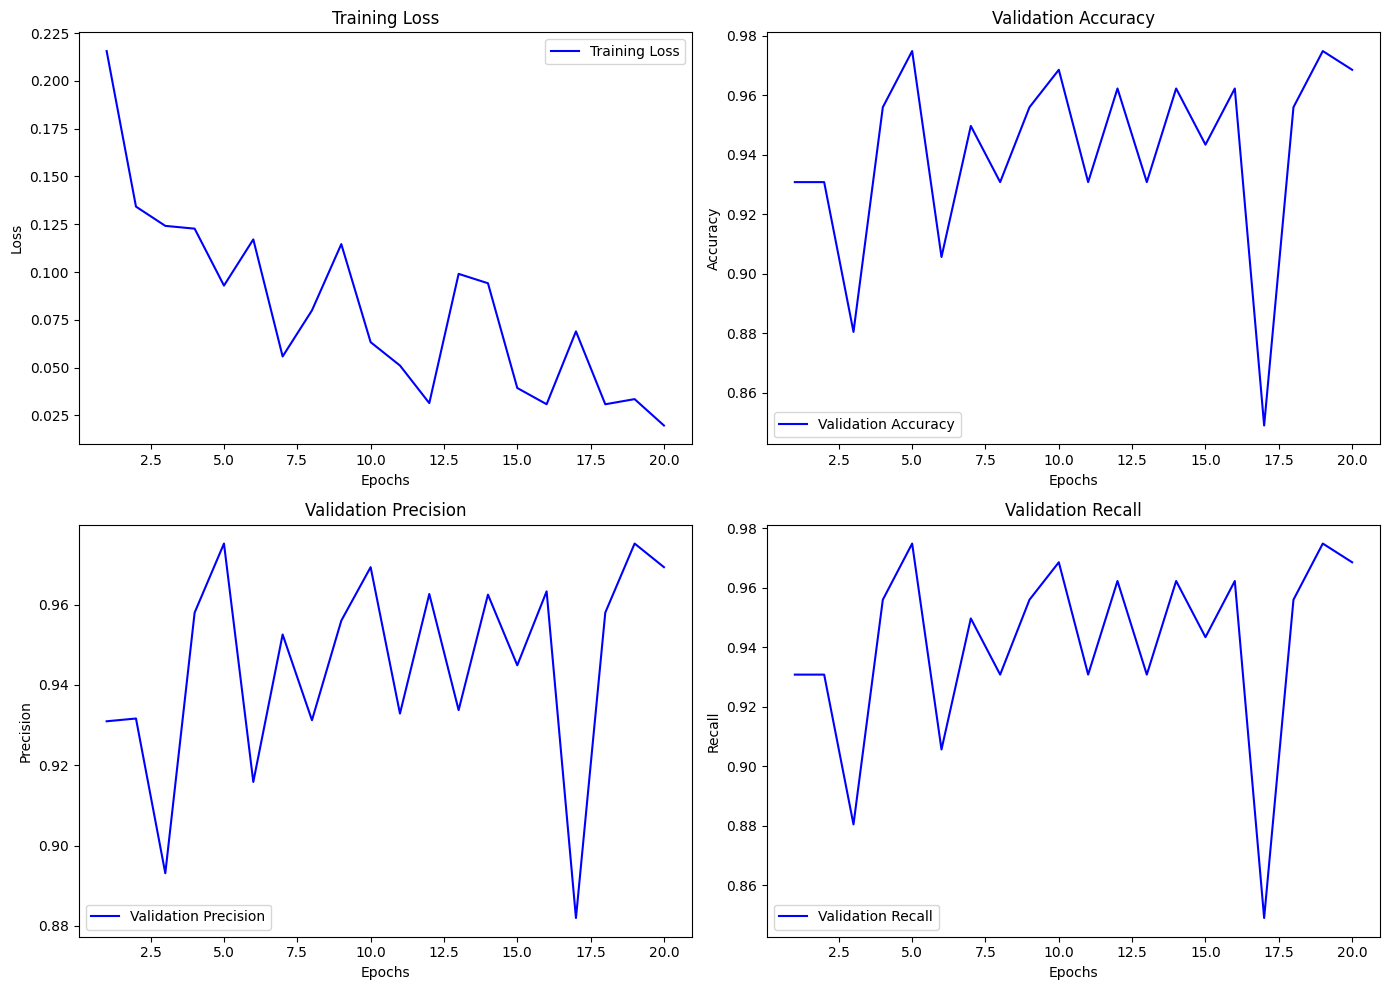

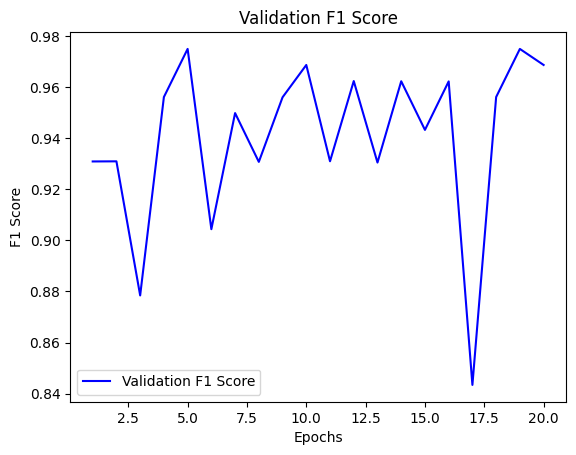

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
log_df = pd.read_csv('training_log.csv')

# Plot the metrics
epochs = log_df['epoch']

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, log_df['train_loss'], 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, log_df['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, log_df['val_precision'], 'b', label='Validation Precision')
plt.title('Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, log_df['val_recall'], 'b', label='Validation Recall')
plt.title('Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, log_df['val_f1'], 'b', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [8]:
# Define the image preprocessing function
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

In [9]:
# Define the image classification function
def classify_image(model, image_tensor, device):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        class_idx = predicted.item()
        return 'Meme' if class_idx == 0 else 'Not Meme'

# Define the function to display the image
def display_image(image_path, label):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Prediction: {label}')
    plt.axis('off')
    plt.show()

### Creating a prediction loop withing a file directory

##### the images gets preprocessed before being passed to the model with the best weights


In [15]:
#same code as before


# Function to classify and display all images in a folder
def classify_and_display_images_in_folder(model, folder_path, device):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            image_tensor = preprocess_image(image_path)
            label = classify_image(model, image_tensor, device)
            print(f'{filename}: {label}')
            display_image(image_path, label)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, 2)  # Adjust the final layer for binary classification (Meme/Not Meme)

# Load your custom-trained model weights
model_weights_path = 'best_model.pth'
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Replace with the path to your image folder
folder_path = 'G:\Projectsdocs\memes\image_folder'

classify_and_display_images_in_folder(model, folder_path, device)

c:\Users\Sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


NameError: name 'preprocess_image' is not defined

### Gradcam implementation

In [16]:
# Define the image preprocessing function
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Hook for gradients
class SaveFeatures:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None
        self.gradients = None

    def hook_fn(self, module, input, output):
        self.features = output
        output.register_hook(self.save_grads)

    def save_grads(self, grads):
        self.gradients = grads

    def remove(self):
        self.hook.remove()


In [17]:
def generate_gradcam(model, input_tensor, device, target_layer):
    model.eval()

    # Hook the feature and gradient for the target layer
    features_hook = SaveFeatures(target_layer)

    # Forward pass
    output = model(input_tensor.to(device))
    target_class = output.argmax(dim=1).item()

    # Backward pass to get the gradients
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # Get the feature maps and gradients
    gradients = features_hook.gradients[0].cpu().data.numpy()
    features = features_hook.features[0].cpu().data.numpy()

    # Compute the Grad-CAM
    weights = np.mean(gradients, axis=(1, 2))
    gradcam_map = np.sum(weights[:, np.newaxis, np.newaxis] * features, axis=0)
    gradcam_map = np.maximum(gradcam_map, 0)
    gradcam_map = cv2.resize(gradcam_map, (input_tensor.shape[3], input_tensor.shape[2]))
    gradcam_map = gradcam_map - np.min(gradcam_map)
    gradcam_map = gradcam_map / np.max(gradcam_map)

    # Visualize the Grad-CAM output
    img = input_tensor.cpu().numpy()[0].transpose((1, 2, 0))
    img = np.float32(img)
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_map), cv2.COLORMAP_JET)

    # Adjust transparency
    alpha = 0.01  # Make the heatmap more transparent
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    superimposed_img = superimposed_img / np.max(superimposed_img)

    return superimposed_img

### Gradcam showing the heatmap of the features responsible for the classification

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


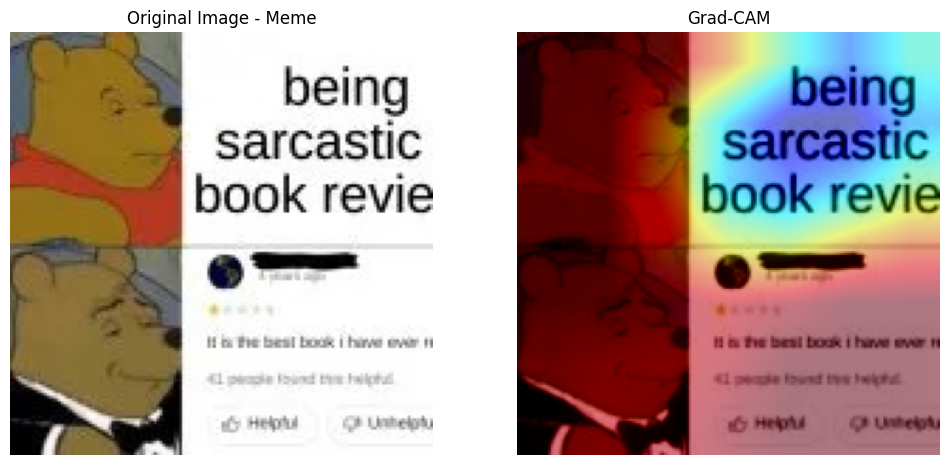

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


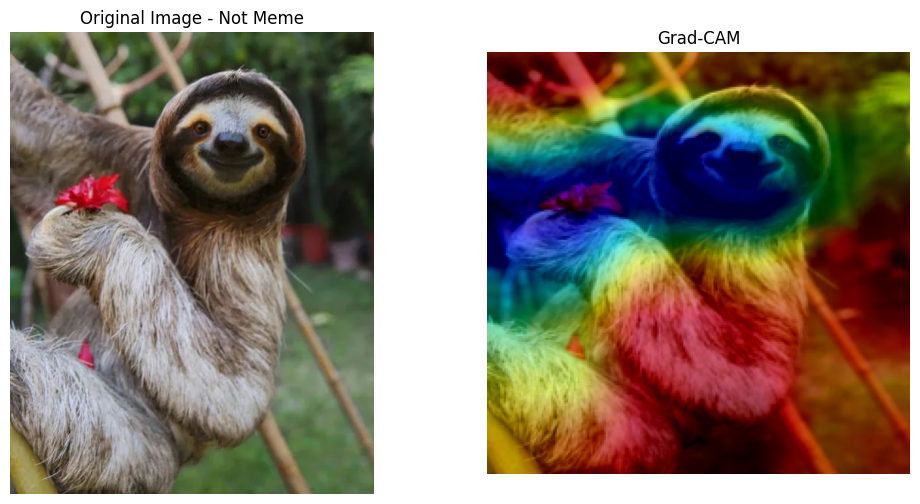

In [18]:
sample_image_path1 = 'G:\Projectsdocs\memes\image_folder\8r06r1.jpg'
sample_input1_tensor = preprocess_image(sample_image_path1)

# The target layer to visualize Grad-CAM for DenseNet
target_layer = model.features.denseblock4

gradcam_img1 = generate_gradcam(model, sample_input1_tensor, device, target_layer)

# original image for display
original_img1 = Image.open(sample_image_path1).convert('RGB')

# the original image and Grad-CAM side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img1)
plt.title('Original Image - Meme')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradcam_img1)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()


sample_image_path2 = r'G:\Projectsdocs\memes\image_folder\happy-rescued-sloth.jpg'
sample_input2_tensor = preprocess_image(sample_image_path2)
gradcam_img2 = generate_gradcam(model, sample_input2_tensor, device, target_layer)
original_img2 = Image.open(sample_image_path2).convert('RGB')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img2)
plt.title('Original Image - Not Meme')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradcam_img2)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

In [19]:
state_dict = torch.load('best_model.pth')
torch.save(state_dict, 'best_model.pt')